### HMM EXERCISE II


#### SETUP
Build a HMM speech recognizer that can distinguish between the two words ME and YOU.  
- The models of each consist of two states (assumed to represent the underlying phonemes). 
- You have one-dimensional continuous observations and will model these with Gaussian distributions.
- You have a small database of example recordings with three example utterances for each word, and corresponding manual phonetic segmentations

The data for ME:
> X = \[4.0 2.5 1.0 2.0 5.0 8.0 \],  S = \[1 1 1 2 2 2\]   
> X = \[4.5 2.0 1.0 1.5 6.5 7.0\],   S = \[1 1 1 2 2 2\]   
> X = \[3.5 2.5 1.5 3.0 7.0\],       S = \[1 1 1 2 2\]   

The data for YOU:
> X= \[1.0 2.0 4.5 8.0 6.5 1.5\] ,   S = \[1 1 1 2 2 2 \]   
> X= \[1.5 2.5 4.0 7.0 3.0 \],       S = \[ 1 1 1 2 2 \]   
> X= \[1.0 2.5 3.5 7.0 5.0 2.0\],    S = \[ 1 1 1 2 2 2 \]   

#### INSTRUCTIONS
The exercises in this notebook require a significant amount of computation.
- Preferably perform each TYPE of computation at least once by HAND
- Rely on the notebook code to verify what you did by HAND and fill in the other computations
- Don't skip the interpretation Questions !  Completely finish TASK 1 before moving on to TASK 2.

#### Task 1
- Use the hand labeled data to build a two-state HMM for each word. 
- Sketch it, adding transition probabilities and (mean, variance) of the observation pdfs.
- Using Viterbi score as a criterion, is a test observation string  more likely to be an example of me or of you? 
    + X_t = \[1.2, 3.1, 4.8, 7.6, 4.3\]
- Critically assess the models and your recognition result
- In view of this assessment, go back and have a look at your observation sequences; a simple sketch should tell you a lot
- Why was it OK to use the Viterbi-score to compare the two model ?  (remember: The Viterbi score is a likelihood and not a model posterior)
    
#### Task 2
For Q2 you should use delta features instead of the original feature vectors
- motivate the use of delta's based on your assessment in Exercise 1
- Observe the delta-feature plots and try to predict how and why newly trained models will work better than the old ones
- retrain the models
- what is the recognition result now ?

#### Addition exercises
- redo recognition on other test samples, eg
    + X_t2 = \[3.1, 2.5, 2.0, 2.0, 2.0,  4.6, 4.9, 5.2, 5.4\] 

In [1]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
# do all the imports
%matplotlib inline

import sys, os
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy
from sklearn import preprocessing

import pyspch.stats.probdist as Densities
from pyspch.stats import libhmm
import pyspch as Spch

# graphical and print preferences
ldesign = 50
cmap = sns.light_palette("caramel",ldesign,input="xkcd")
cmap20 = cmap[0:20] 
cmap="OrRd_r"
pd.reset_option('display.float_format')
pd.set_option('display.precision',3)
mpl.rcParams['figure.figsize'] = [12.0, 6.0]
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlepad'] = 15
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.linewidth'] = 2
mpl.rc('lines', linewidth=3, color='k')

We define class **hmm_x** which is a super class of the **libhmm.hmm** class.   
We do this to highlight the implementation of 3 methods used in this notebook
with minimal code, but adapted to the problems handled here.
- training routine .fit()
- recognition routine .recognize()
- scoring routine .predict_proba()

In [3]:
class hmm_x(libhmm.HMM):
    
    def fit(self,X,y):
        '''
        fit() takes a sequence of observations X together with their state (index) alignments y
        '''
        # training of the observation probabilities
        self.obs_model.fit(np.concatenate(X),np.concatenate(y))
            
        # train initial and transition probabilities
        init_counts = np.zeros(self.n_states,dtype='float')
        trans_counts = np.zeros((self.n_states,self.n_states),dtype='float')         
        for (Xi,yi) in zip(X,y):
            init_counts[yi[0]] += 1.
            for j in range(1,Xi.shape[0]):
                trans_counts[ yi[j-1],yi[j] ] += 1.
        self.transmat = trans_counts / np.sum(trans_counts,axis=1)[:,np.newaxis]
        self.initmat = init_counts / np.sum(init_counts)
        if self.prob_style == "log":
            self.transmat = Spch.logf(self.transmat)
            self.initmat = Spch.logf(self.initmat)

    def align(self,X=None,method='Viterbi',end_states=None):
        '''
        Viterbi alignment for the current HMM model and observation sequence X
        This method allows to list allowed end_states, default is last state defined in the model
        '''
        trellis = libhmm.Trellis(self)
        trellis.viterbi_pass(X)
        seq_prob,end_state = trellis._finalize(end_states=end_states)
        return  trellis.backtrace(end_state=end_state)
    
    # find the HMM likelihood score for input sequences for the best admissible end_states
    def predict_proba(self,X=None,method='Viterbi',end_states=None):
        results = np.array([])
        for Xi in X:
            trellis = libhmm.Trellis(self)
            if method == "Viterbi":
                trellis.viterbi_pass(Xi)
            else:
                trellis.forward_pass(Xi)
            seq_prob,_ = trellis._finalize(end_states=end_states)
            results = np.append(results,seq_prob)
        return results

    # find the HMM likelihood score for input sequences for all admissible end_states
    def recognize(self,X=None,method='Viterbi',end_states=None,Print=True):
        if end_states is None: end_states = self.end_states
        results = []
        for Xi in X:
            results_i = []
            trellis = libhmm.Trellis(self)
            if method == "Viterbi":
                trellis.viterbi_pass(Xi)
            else:
                trellis.forward_pass(Xi)
            for end_state in end_states:
                seq_prob,_ = trellis._finalize(end_states=[end_state])
                results_i.append((end_state,seq_prob))
            results.append(results_i)
        if(Print):
            for i in range(len(results)):
                print("\n== Sample (%d) === " %i)
                for res in results[i]:
                    (end_s,score) = res
                    print('Endstate=%s, score=%.2e' % (self.states[end_s],score) )
        return results

In [4]:
# CODE BLOCK FOR FEATURE TRANSFORMATION and AUGMENTATION
#
# padding copies the edge frames N times 
# e.g.   padding sequence [a,b,c,d] with 2 frames will result in 
#                     [a,a,a,b,c,d,d,d]
def pad_time(X,N = 1):
    X_padded = np.pad(X,[(N,N),(0,0)],mode='edge')
    return X_padded

# deltas are computed as first order difference: 
# delta_x(t) = x(t+1) - x(t-1) ; the input sequence is padded at the edges
def deltas(X):
    X_p = pad_time(X,N=1)
    delta_X = X_p[2:,:] - X_p[0:-2,:]
    return delta_X

# splice 2*N+1 frames , i.e. add Ns frames on left and right side
# to the current feature vector and stack everything in a high dimensional supervector
def splice(X,N=1):
    X_p = pad_time(X,N=N)
    X_s = X
    T = X.shape[0]
    for i in range(1,N+1):
        X_s = np.concatenate( (X_p[N-i:N-i+T,:],X_s,X_p[N+i:N+i+T,:]), axis=1)
    return X_s

# merges two feature streams into one
def merge(Xarray):
    X_m = np.concatenate(Xarray,axis=1)
    return X_m

# utility to compute variants of augmented features
def compute_augmented_features(X):
    X_delta = []
    X_aug=[]
    X_seg=[]
    for Xi in X: 
        Xid = deltas(Xi)
        X_delta.append(Xid)
        X_aug.append( merge((Xi,Xid)) )
        X_seg.append( splice(Xi,N=1) )
    return X_delta, X_aug, X_seg

In [5]:
# CODE BLOCK FOR GENERATING RANDOM EXTRA SAMPLES
#
# the routine returns regular features, deltas and augmented features
import random
def generate_random_sequence(seed=None):
    random.seed(None)
    ii = [ random.randint(3,6) for i in range(2) ]
    ss = [ random.gauss(0.,.5) for i in range(2) ]
    x1 = ss[0]*np.arange(ii[0]) - ss[0]*ii[0]/2 + 2.5
    x2 = ss[1]*np.arange(ii[1]) - ss[1]*ii[1]/2 + 5
    X=np.concatenate([x1,x2])
    X = X+ np.array([ random.gauss(0.,1.) for i in range(ii[0]+ii[1])])
    X=X.reshape(-1,1)
    Xd = deltas(X)
    Xa = merge((X,Xd))

    return(X,Xd,Xa)

## TASK 1

In [6]:
# CODE BLOCK FOR GENERATING THE DATA
# first define the phone set and make a hashing index to map labels to index
phones = np.array(["M","IY","Y","UW"])
ph2indx = dict( zip(phones, range(0,len(phones))) )
#
# Example Data for "me" and "you"
#
X_ME = [
 np.array([4.0,2.5,1.0,2.0,5.0,8.0]).reshape(-1,1), 
 np.array([4.5,2.0,1.0,1.5,6.5,7.0]).reshape(-1,1), 
 np.array([3.5,2.5,1.5,3.0,7.0]).reshape(-1,1)
]
ph_ME = [
    np.array(["M","M","M","IY","IY","IY"]),
    np.array(["M","M","M","IY","IY","IY"]),
    np.array(["M","M","M","IY","IY"]) 
]

X_YOU = [
 np.array([1.0,2.0,4.5,8.0,6.5,1.5]).reshape(-1,1), 
 np.array([1.5,2.5,4.0,7.0,3.0]).reshape(-1,1), 
 np.array([1.0,2.5,3.5,7.0,5.0,2.0]).reshape(-1,1)
]
ph_YOU = [
 np.array([ "Y","Y","Y","UW","UW","UW"]),
 np.array([ "Y","Y","Y","UW","UW"]),
 np.array([ "Y","Y","Y","UW","UW","UW"]) 
]

# training feature vectors
X_train =  X_ME + X_YOU
# training alignments (labels)
ph_train = ph_ME + ph_YOU 
# training indices for all alignments
y_train = [ np.array( [ ph2indx[x] for x in ph ]) for ph in ph_train ] 

## test utterances
X_test = [np.array([1.2, 3.1, 4.8, 7.6, 4.3]).reshape(-1,1)]
# extra test utterances
#X_test = [np.array([1.2, 3.1, 4.8, 7.6, 4.3]).reshape(-1,1),
#        np.array([3.1, 2.5, 2.0, 2.0, 2.0,  4.6, 4.9, 5.2, 5.4]).reshape(-1,1) ] 

## Training an observation model
All observations for all classes are all stacked together as one long observation sequence with associated labels.
For the purpose of training the observation model, all observations are assumed independent and the order doesn't matter.
The .fit() method will estimate the ML estimate of the Gaussian (mixture) density.
The different classes (M,IY,Y,UW) are represented by their associated indices (0,1,2,3).
Thus, interpreting the model: class 0 is N(mu=2.5,var=1.444), class(1) is N(mu=5., var=5.5625), ...

In [7]:
Gauss1 = Densities.Gaussian()
Gauss1.fit(np.concatenate(X_train),np.concatenate(y_train))
Gauss1.print_model(precision=3)

,prior,mean,var
0,0.265,[2.5],[1.4444444493838908]
1,0.235,[5.0],[5.562500004939446]
2,0.265,[2.5],[1.4444444493838908]
3,0.235,[5.0],[5.562500004939446]


## Creating HMM and Trellis for Recognition
- initializing the HMM with 
    + observation propabilities as trained above
    + 4 states for each of the known phonemes
    + transitions possible for M->IY and Y->UW
 
- use a TRELLIS for recognition
    + complete the finite state transition model 
        with 'M' and 'IY' as acceptable initial states
        'IY' and 'UW' are defined as admissible END STATES

- By our setup above we can "read out" the observation probabilities for ME and YOU in the last column of the trellis
in the states IY and UW. Comparing the two probabilities lets you decide on which word was spoken.
Note that you could have used prior word probabilities by having different initial probabilities for the M and Y states.
 
- we set computations to use 'log-probabilities' (but you can turn that off)
- evaluate log-prob of a single sample X_test

In [18]:
Amat = np.eye(4)
Amat[0,1] = 1
Amat[2,3] = 1
Imat = np.array([1.0, 0., 1., 0.0])
hmm1= hmm_x(obs_model=Gauss1, states=phones,transmat=Amat,initmat =Imat, end_states=[1,3])
# comment the next line if you prefer "probabilities" over of "log-probabilities" 
hmm1.set_probstyle("log")
hmm1.print_model()


HMM STATE MODEL



,M,IY,Y,UW
Pinit(.),0.0,-89.801,0.0,-89.801


,M,IY,Y,UW
P(M|.),0.000,-89.801,-89.801,-89.801
P(IY|.),0.000,0.000,-89.801,-89.801
P(Y|.),-89.801,-89.801,0.000,-89.801
P(UW|.),-89.801,-89.801,0.000,0.000



OBSERVATION MODEL



,prior,mean,var
0,0.265,[2.5],[1.4444444493838908]
1,0.235,[5.0],[5.562500004939446]
2,0.265,[2.5],[1.4444444493838908]
3,0.235,[5.0],[5.562500004939446]


In [19]:
tr1 = libhmm.Trellis(hmm1)
tr1.viterbi_pass(X_test[0])
tr1.print_trellis()


Observation Probabilities



,0,1,2,3,4
M,-1.688,-1.227,-2.934,-10.106,-2.224
IY,-3.075,-2.101,-1.781,-2.385,-1.821
Y,-1.688,-1.227,-2.934,-10.106,-2.224
UW,-3.075,-2.101,-1.781,-2.385,-1.821



Trellis Probabilities (Viterbi)



,0,1,2,3,4
M,-1.688,-2.915,-5.849,-15.955,-18.180
IY,-92.876,-3.789,-4.696,-7.080,-8.901
Y,-1.688,-2.915,-5.849,-15.955,-18.180
UW,-92.876,-3.789,-4.696,-7.080,-8.901



Alignment



,0,1,2,3,4
VIT-ALIGN,M,M,IY,IY,IY



Sequence Probability: -8.90e+00



## A TRAINED model
- the observation probabilities will be the same as aboved as trained on the same segmentation
- the transitions will now have true probabilities associated with them

In [20]:
Gauss2 = copy.deepcopy(Gauss1)
hmm2 = hmm_x(obs_model=Gauss2, states=phones,transmat=Amat,end_states=[1,3])
hmm2.set_probstyle("log")
hmm2.fit(X_train,y_train)
hmm2.print_model()


HMM STATE MODEL



,M,IY,Y,UW
Pinit(.),-0.693,-89.801,-0.693,-89.801


,M,IY,Y,UW
P(M|.),-0.405,-89.801,-89.801,-89.801
P(IY|.),-1.099,0.000,-89.801,-89.801
P(Y|.),-89.801,-89.801,-0.405,-89.801
P(UW|.),-89.801,-89.801,-1.099,0.000



OBSERVATION MODEL



,prior,mean,var
0,0.265,[2.5],[1.4444444493838908]
1,0.235,[5.0],[5.562500004939446]
2,0.265,[2.5],[1.4444444493838908]
3,0.235,[5.0],[5.562500004939446]


### Evaluating trained models

Two methods are provided to evaluate data on an HMM, using one pass dynamic programming in a trellis
- .predict_proba() finds the BEST score for a list of test samples; you can specify admissible end_states
- .recognize()     lists the score for ALL admissible end_states

While the training samples are obviously different for both words, we obtain the same score on both words. 
This seems to be true for all samples.
This is due to the fact that the HMMs models states as stationary processes that do not take into account the data order WITHIN a state. In this example both words have identical distributions; however the distintive feature between the two models is the order of the data which is not captured by the HMMs in the default setup.

In [21]:
# compare the likelihoods of the trained models with the initialization model for test samples
#
for XX in X_test:
    print("Test sample: ", XX.T)
    print("Scores on finite state hmm: ",hmm1.predict_proba([XX]))
    print("Scores on trained hmm for 'ME': ", hmm2.predict_proba([XX],end_states=[1]))
    print("Scores on trained hmm for 'YOU': ",hmm2.predict_proba([XX],end_states=[3]))

Test sample:  [[1.2 3.1 4.8 7.6 4.3]]
Scores on finite state hmm:  [-8.9013852]
Scores on trained hmm for 'ME':  [-11.09860978]
Scores on trained hmm for 'YOU':  [-11.09860978]


In [22]:
hmm2.recognize(X_test,end_states=[1,3]);


== Sample (0) === 
Endstate=IY, score=-1.11e+01
Endstate=UW, score=-1.11e+01


### Feature Plots

The figures show training examples of both words vs. the test observation.

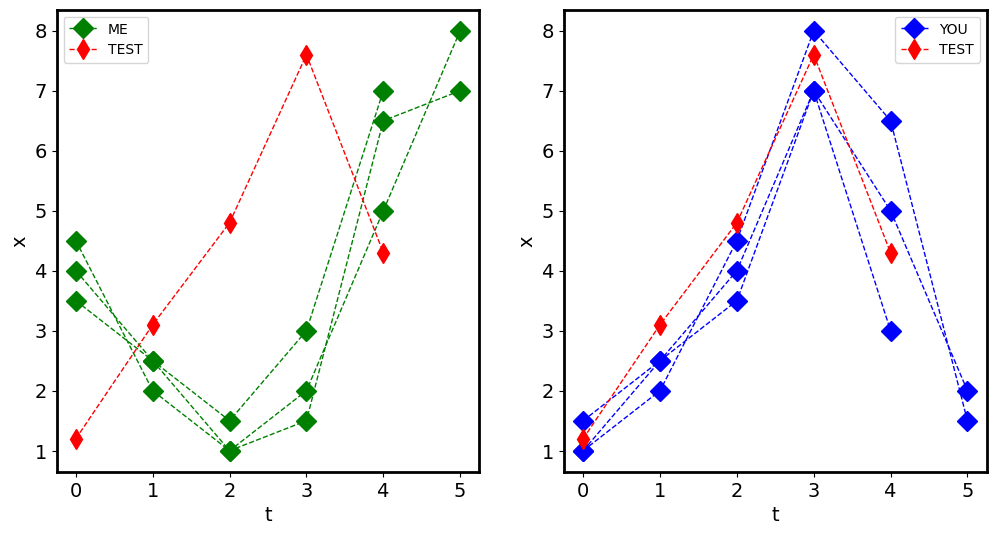

In [24]:
fig,ax = plt.subplots(1,2)
kw1=dict(ls='--',lw=1,ms=10)
kw2=dict(fontsize=14)
words = ['ME','YOU']
data = [X_ME,X_YOU]
fmts = ['gD','bD']
for k in (0,1):    
    for X in data[k]:
        lx, = ax[k].plot(X,fmts[k],**kw1,label=words[k])
    lt, = ax[k].plot(X_test[0],'rd',**kw1,label='TEST')
    ax[k].legend(handles=[lx,lt])
    ax[k].set_xlabel("t",**kw2)
    ax[k].set_ylabel("x",**kw2)

## TASK 2

###  Feature Transformations : Delta's, Segmental Features, ...
The feature transformations we use here have the sole intention to put emphasis on local in time trends in the data that may not be captured by a naive HMM.   
In all cases we construct a new feature vector that has a wider look on the data.  
There are principally 2 possibilities to achieve this:
- using segmental input by splicing a number of frames together
    + this keeps all original segmental information together
    + but has as negative side effect that information gets strongly correlated
- using delta features 
    + here we augment the feature vector with the derivatives over time
    + this has as great advantage that the augmented features are quite decorrelated from the original feature vector
    
For each of these operations we need to take special care about the edges , i.e. start and end of our sequence data.   The standard procedure is to pad the original sequence on the left and right with the required number of frames to make a transformed sequence of equal length that can still be aligned with the original label sequence.  Assuming that frames are more or less stationary locally in time, it makes sense to extend the sequence data with copies of the edge values.

In [25]:
# now compute 
## a. delta features
## b. augmented features comprising original+deltas
## c. segmental features comprising 3 frames of data (same data span as deltas)
#
X_delta, X_aug, X_seg = compute_augmented_features(X_train)
X_test_delta, X_test_aug, X_test_seg = compute_augmented_features(X_test)
# X_delta, X_test_delta
#print("Delta Features (training): ",X_delta)

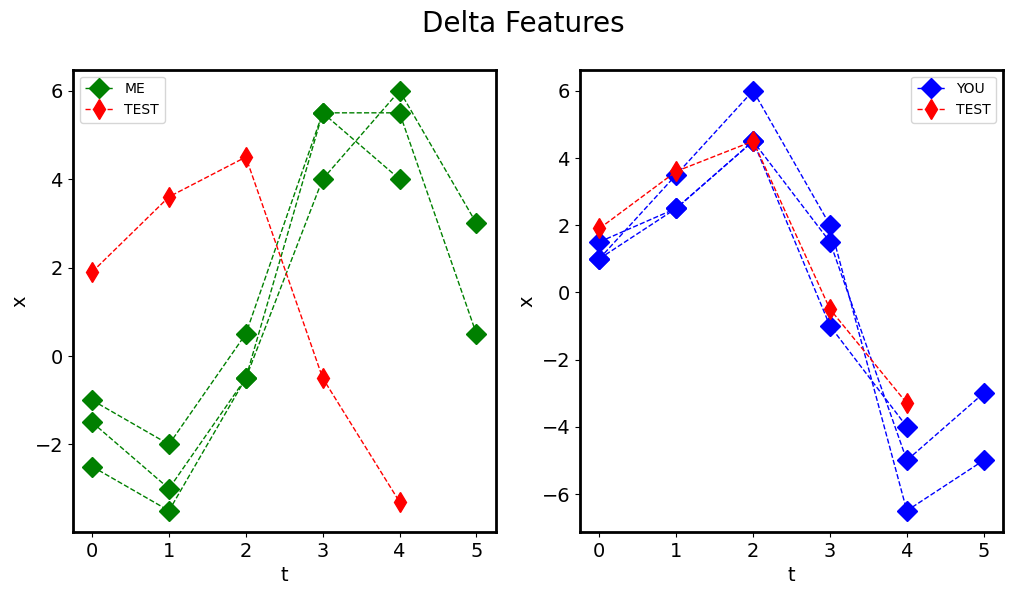

In [26]:
fig,ax = plt.subplots(1,2)
kw1=dict(ls='--',lw=1,ms=10)
kw2=dict(fontsize=14)
words = ['ME','YOU']
data = [X_delta[0:3],X_delta[3:6]]
fmts = ['gD','bD']
for k in (0,1):    
    for X in data[k]:
        lx, = ax[k].plot(X,fmts[k],**kw1,label=words[k])
    lt, = ax[k].plot(X_test_delta[0],'rd',**kw1,label='TEST')
    ax[k].legend(handles=[lx,lt])
    ax[k].set_xlabel("t",**kw2)
    ax[k].set_ylabel("x",**kw2)
fig.suptitle("Delta Features",fontsize=20);

## Train new models with delta features

- hmm3 : trained on delta features only (delta's replace X)
- hmm4 : trained on augmented features ( delta's are added to X )

In [27]:
#
print("++++++++ MODEL WITH DELTA's ONLY ++++++++")
hmm3 = copy.deepcopy(hmm2)
hmm3.fit(X_delta,y_train)
hmm3.print_model()
#
print("++++++++ AUGMENTED MODEL WITH DELTA's ++++++++")
hmm4 = copy.deepcopy(hmm2)
hmm4.fit(X_aug,y_train)
hmm4.print_model()
#

++++++++ MODEL WITH DELTA's ONLY ++++++++

HMM STATE MODEL



,M,IY,Y,UW
Pinit(.),-0.693,-89.801,-0.693,-89.801


,M,IY,Y,UW
P(M|.),-0.405,-89.801,-89.801,-89.801
P(IY|.),-1.099,0.000,-89.801,-89.801
P(Y|.),-89.801,-89.801,-0.405,-89.801
P(UW|.),-89.801,-89.801,-1.099,0.000



OBSERVATION MODEL



,prior,mean,var
0,0.265,[-1.5555555555555556],[1.524691370189916]
1,0.235,[4.25],[2.937500012165225]
2,0.265,[3.0],[2.722222234387447]
3,0.235,[-2.625],[8.671875012165225]


++++++++ AUGMENTED MODEL WITH DELTA's ++++++++

HMM STATE MODEL



,M,IY,Y,UW
Pinit(.),-0.693,-89.801,-0.693,-89.801


,M,IY,Y,UW
P(M|.),-0.405,-89.801,-89.801,-89.801
P(IY|.),-1.099,0.000,-89.801,-89.801
P(Y|.),-89.801,-89.801,-0.405,-89.801
P(UW|.),-89.801,-89.801,-1.099,0.000



OBSERVATION MODEL



,prior,mean,var
0,0.265,"[2.5, -1.5555555555555556]","[1.4444444566096692, 1.524691370189916]"
1,0.235,"[5.0, 4.25]","[5.562500012165225, 2.937500012165225]"
2,0.265,"[2.5, 3.0]","[1.4444444566096692, 2.722222234387447]"
3,0.235,"[5.0, -2.625]","[5.562500012165225, 8.671875012165225]"


### Recognize with the different Models



In [28]:
#
print("++ RESULTS with BASELINE FEATURES ++")
hmm2.recognize(X_test,end_states=[1,3]);
#
print("\n\n++ RESULTS with DELTA FEATURES ++")
hmm3.recognize(X_test_delta,end_states=[1,3]);
print("\n\n++ RESULTS with AUGMENTED FEATURES [X,Deltas] ++")
hmm4.recognize(X_test_aug,end_states=[1,3]);

++ RESULTS with BASELINE FEATURES ++

== Sample (0) === 
Endstate=IY, score=-1.11e+01
Endstate=UW, score=-1.11e+01


++ RESULTS with DELTA FEATURES ++

== Sample (0) === 
Endstate=IY, score=-2.63e+01
Endstate=UW, score=-1.18e+01


++ RESULTS with AUGMENTED FEATURES [X,Deltas] ++

== Sample (0) === 
Endstate=IY, score=-3.61e+01
Endstate=UW, score=-2.19e+01


## EXTRA MATERIALS 
#### MAKE YOUR PERSONAL EXERCISE !!

#### STEP0: Train all the models above
Be sure you have trained the models hmm3 and hmm4 as described above.
They are required in this exercise.

#### STEP1:  FILL IN YOUR student ID to generate your personal test sequences

You can run this exercise with a dummy ID as provided or with your personal student ID.

In [29]:
student_id = 's0123456'
MY_X,MY_Xd,MY_Xa= generate_random_sequence(seed=student_id)

#### STEP2: Compute a Trellis for the model with Deltas and your test sample

In [30]:
hmm3.print_model()


HMM STATE MODEL



,M,IY,Y,UW
Pinit(.),-0.693,-89.801,-0.693,-89.801


,M,IY,Y,UW
P(M|.),-0.405,-89.801,-89.801,-89.801
P(IY|.),-1.099,0.000,-89.801,-89.801
P(Y|.),-89.801,-89.801,-0.405,-89.801
P(UW|.),-89.801,-89.801,-1.099,0.000



OBSERVATION MODEL



,prior,mean,var
0,0.265,[-1.5555555555555556],[1.524691370189916]
1,0.235,[4.25],[2.937500012165225]
2,0.265,[3.0],[2.722222234387447]
3,0.235,[-2.625],[8.671875012165225]


In [31]:
trellis3 = libhmm.Trellis(hmm3)
trellis3.viterbi_pass(MY_Xd)
trellis3.print_trellis(what=['obs_probs','probs','backpointers','alignment'])


Observation Probabilities



,0,1,2,3,4,5,6,7,8
M,-1.152,-1.599,-4.277,-4.601,-4.580,-1.378,-1.797,-6.505,-3.883
IY,-6.697,-5.074,-2.706,-2.566,-2.575,-5.605,-4.722,-1.983,-2.897
Y,-4.812,-3.492,-1.810,-1.731,-1.736,-3.915,-3.218,-1.467,-1.925
UW,-2.101,-2.295,-3.000,-3.076,-3.072,-2.216,-2.358,-3.509,-2.906



Trellis Probabilities (Viterbi)



,0,1,2,3,4,5,6,7,8
M,-1.845,-3.849,-8.532,-13.538,-18.524,-20.307,-22.510,-29.420,-33.708
IY,-96.497,-8.017,-7.654,-10.220,-12.795,-18.400,-23.122,-25.106,-28.003
Y,-5.505,-9.403,-11.619,-13.755,-15.896,-20.217,-23.841,-25.714,-28.044
UW,-91.901,-8.899,-11.899,-14.976,-17.925,-19.211,-21.569,-25.078,-27.984



Backpointers



,0,1,2,3,4,5,6,7,8
M,M,M,M,M,M,M,M,M,M
IY,UW,M,M,IY,IY,IY,IY,IY,IY
Y,Y,Y,Y,Y,Y,Y,Y,Y,Y
UW,UW,Y,UW,UW,Y,Y,UW,UW,UW



Alignment



,0,1,2,3,4,5,6,7,8
VIT-ALIGN,Y,Y,Y,Y,Y,UW,UW,UW,UW


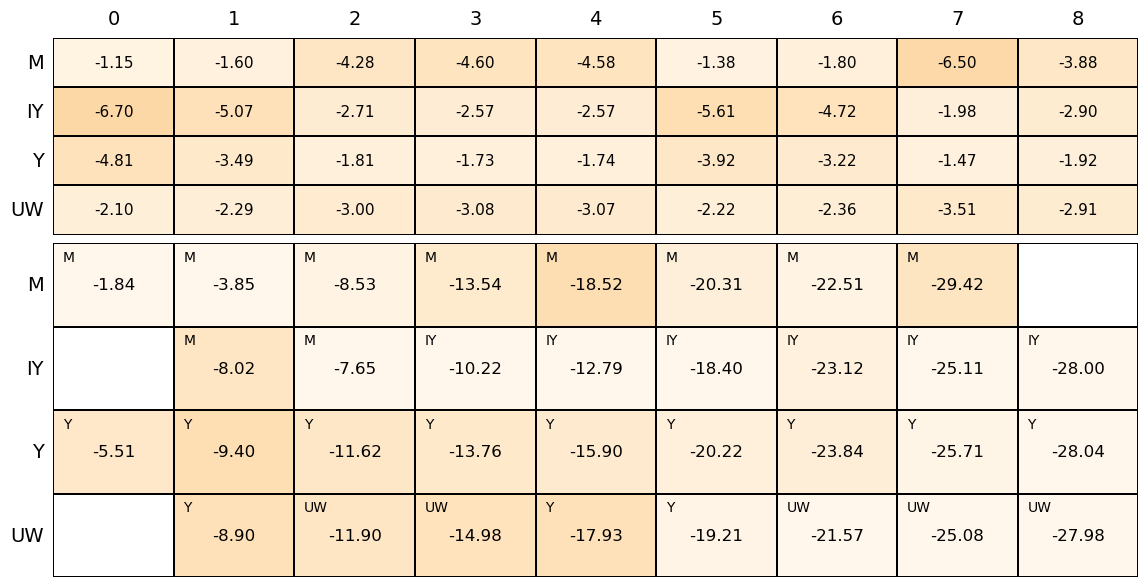

In [32]:
trellis3.plot_trellis(plot_obs_probs=True,plot_backptrs=True,cmap=cmap,
                plot_norm=True,vmin=-30.,vmax=0,cmapf=None,fmt=".2f",figsize=(14,7))

#### STEP3: Compute a Trellis for the model with Augmented features your test sample

In [33]:
hmm4.print_model()


HMM STATE MODEL



,M,IY,Y,UW
Pinit(.),-0.693,-89.801,-0.693,-89.801


,M,IY,Y,UW
P(M|.),-0.405,-89.801,-89.801,-89.801
P(IY|.),-1.099,0.000,-89.801,-89.801
P(Y|.),-89.801,-89.801,-0.405,-89.801
P(UW|.),-89.801,-89.801,-1.099,0.000



OBSERVATION MODEL



,prior,mean,var
0,0.265,"[2.5, -1.5555555555555556]","[1.4444444566096692, 1.524691370189916]"
1,0.235,"[5.0, 4.25]","[5.562500012165225, 2.937500012165225]"
2,0.265,"[2.5, 3.0]","[1.4444444566096692, 2.722222234387447]"
3,0.235,"[5.0, -2.625]","[5.562500012165225, 8.671875012165225]"


In [34]:
trellis4 = libhmm.Trellis(hmm4)
trellis4.viterbi_pass(MY_Xa)
trellis4.print_trellis(what=['obs_probs','probs','backpointers','alignment'])


Observation Probabilities



,0,1,2,3,4,5,6,7,8
M,-2.385,-2.863,-5.403,-5.960,-7.004,-4.728,-3.456,-9.632,-9.880
IY,-8.793,-7.761,-4.935,-4.585,-4.379,-7.382,-6.636,-3.761,-4.817
Y,-6.046,-4.756,-2.935,-3.090,-4.160,-7.265,-4.877,-4.594,-7.922
UW,-4.197,-4.982,-5.230,-5.095,-4.875,-3.993,-4.272,-5.287,-4.826



Trellis Probabilities (Viterbi)



,0,1,2,3,4,5,6,7,8
M,-3.079,-6.347,-12.155,-18.520,-25.930,-31.063,-34.924,-44.962,-55.248
IY,-98.594,-11.939,-12.381,-16.966,-21.345,-28.727,-35.363,-39.124,-43.941
Y,-6.739,-11.901,-15.242,-18.737,-23.302,-30.973,-36.256,-41.256,-49.584
UW,-93.998,-12.820,-18.050,-21.436,-24.711,-28.394,-32.666,-37.952,-42.778



Backpointers



,0,1,2,3,4,5,6,7,8
M,M,M,M,M,M,M,M,M,M
IY,UW,M,M,IY,IY,IY,IY,IY,IY
Y,Y,Y,Y,Y,Y,Y,Y,Y,Y
UW,UW,Y,UW,Y,Y,Y,UW,UW,UW



Alignment



,0,1,2,3,4,5,6,7,8
VIT-ALIGN,Y,Y,Y,Y,Y,UW,UW,UW,UW


### Questions
    
- Verify by hand column 4 (label '3') of the trellis computed with the delta features.  Simplify your computations by setting very small probabilities to zero.  Would it be easier to do so using probabilities instead of log-probs ?
- The scores obtained in the trellis with 'augmented features' are significantly lower than for 'delta features' alone.  Is this an indication that the 'augmented features' are actually worse than the 'delta features' alone ?   Is your answer generic or specific to the underlying models or specific to the applied techniques ? 